![logo](../../../LogoLine_horizon_C3S.png)

# Lake Victoria’s 2020 Flood Event Analysis

Production date: 29-08-2025

Produced by: Amaya Camila Trigoso Barrientos (VUB)

## 🌍 Use case: Detection and quantification of the 2020 Lake Victoria flood event through statistical analysis

## ❓ Quality assessment question
* **Can the C3S Lake Water Levels dataset be used to conduct extreme value analyses to detect and quantify flood events?**

In 2020, Lake Victoria experienced an extreme flood event with significant regional impacts. Accurate definition and characterization of such events are essential for understanding their causes and informing adaptation strategies. This notebook explores whether the [Lake water levels from 1992 to present derived from satellite observations](https://cds.climate.copernicus.eu/datasets/satellite-lake-water-level?tab=overview) (C3S-LWL v5.0) dataset, a freely available and harmonized satellite-derived product, is suitable for defining high-impact flood events through statistical analysis.

Inspired by methodologies such as those applied by Pietroiusti et al. (2024) [[1]](https://esd.copernicus.org/articles/15/225/2024/) using the DAHITI dataset, this analysis applies extreme value analysis (EVA) to assess the 2020 flood event. The goal is to evaluate whether C3S-LWL v5.0 can serve as a reliable resource for event definition in impact attribution workflows, particularly in data-scarce regions like the Lake Victoria basin.

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* The assessment indicates the C3S Lake Water Levels dataset is suitable to detect and characterise flood events, identifying the 2020 Lake Victoria flood event and ranking it as the third-highest 180-day lake level rise in the historical record (1948–2023), with only 1962 and 1998 recording greater increase.

* Differences between DAHITI and C3S-LWL v5.0 are more pronounced in the early record (1992–2002), due to limited satellite coverage and distinct processing approaches, but these differences shrink substantially after 2002. In recent years, the two datasets show very close agreement.
```

## 📋 Methodology

First, the C3S LWL and the DAHITI datasets of Lake Victoria’s water levels were compared. Both datasets are based on satellite altimetry but differ in their processing algorithms. We evaluated the two datasets in terms of temporal completeness and analysed the causes of their discrepancies. This comparison was motivated by the fact that DAHITI was used in Pietroiusti et al. (2024) [[1]](https://esd.copernicus.org/articles/15/225/2024/) for extreme event attribution (EEA) of the 2020 Lake Victoria flood. Our goal was to assess whether the C3S LWL dataset could serve as a suitable alternative to DAHITI for this type of application. To extend the record, a reconstructed lake level dataset was also built using HYDROMET data, which covers a period prior to satellite-based products. Finally, since lake level data is primarily required during the event definition step of the EEA process, we focused on this first step and tested its implementation using the C3S LWL dataset. The same procedure as on Pietroiusti et al. (2024) [[1]](https://esd.copernicus.org/articles/15/225/2024/) was followed for the event definition, which involved the calculation and ranking of the annual block maximum of the chosen variable, which was the rate of change in water levels over a time window.

The analysis and results are organised in the following steps, which are detailed in the sections below:

**[](satellite_satellite-lake-water-level_climate-and-weather-extremes_q01:section-1)**
 * Download C3S–LWL v5.0 satellite-lake-water-level data for Lake Victoria.

**[](satellite_satellite-lake-water-level_climate-and-weather-extremes_q01:section-2)**
 * Load and preprocess DAHITI data.
 * Plot monthly count of data recorded for both the DAHITI and C3S data.
 * Plot C3S and DAHITI’s Water Level and show the maximum difference.

**[](satellite_satellite-lake-water-level_climate-and-weather-extremes_q01:section-3)**
 * Load and preprocess HYDROMET data.
 * Calculate the average difference between HYDROMET and C3S-LWL overlapping data and correct the HYDROMET dataset based on this.
 * Interpolate to fill missing gaps in HYDROMET.
 * Plot reconstructed time series.

**[](satellite_satellite-lake-water-level_climate-and-weather-extremes_q01:section-4)**
 * Apply the annual block maxima to the reconstructed time series.
 * Compare with the results from Pietroiusti et al. (2024) [[1]](https://esd.copernicus.org/articles/15/225/2024/).


## 📈 Analysis and results

(satellite_satellite-lake-water-level_climate-and-weather-extremes_q01:section-1)=
### 1. Data request and download

#### Import packages
Import the packages to download the data using the c3s_eqc_automatic_quality_control library.

In [2]:
import warnings
import numpy as np
import pooch
import matplotlib.pyplot as plt
from c3s_eqc_automatic_quality_control import download
import pandas as pd
import matplotlib.dates as mdates
import pprint
import os , glob
import scipy as scipy
from scipy import stats
from scipy.stats import genextreme
import sklearn 
import datetime
from datetime import datetime
from matplotlib.pyplot import cm

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-notebook")

#### Set the data request
Set the request for the specific lake (Victoria in our case) analyzed and the collection id (satellite lake water level).

In [3]:
collection_id = "satellite-lake-water-level"
request = {
    "variable": "all",
    "region": "southern_africa",
    "lake": "victoria",
}
varname = "water_surface_height_above_reference_datum"

#### Download data

In [4]:
da = download.download_and_transform(collection_id, request)[varname].compute()

100%|██████████| 1/1 [00:00<00:00, 20.35it/s]


(satellite_satellite-lake-water-level_climate-and-weather-extremes_q01:section-2)=
### 2. Comparison of C3S LWL with the DAHITI dataset

#### Load and preprocess DAHITI data

This assessment applies the methods developed by Pietroiusti et al. (2024) [[1]](https://esd.copernicus.org/articles/15/225/2024/), whose data are openly available via [Zenodo](https://zenodo.org/records/10793917). In that study, the DAHITI dataset [[2]](https://hess.copernicus.org/articles/19/4345/2015/hess-19-4345-2015.html) was employed. Accordingly, a comparison of Lake Victoria’s water level time series from C3S-LWL v5.0 and DAHITI will be carried out. The DAHITI time series for Lake Victoria can be accessed and downloaded from the [DAHITI portal](https://dahiti.dgfi.tum.de/en/2/water-level-altimetry/). 

For reproducibility, the specific DAHITI dataset used in this assessment is located in the [Zenodo](https://zenodo.org/records/10793917) repository at: lakevic-eea-data-zenodo\lakevic-eea-data-zenodo\lakevic-eea-analysis\lakelevels\DAHITI_lakelevels_070322.csv.

In [5]:
# Load data
pietroiusti_paper_url = (
    "https://zenodo.org/records/10793917/files/lakevic-eea-data-zenodo.zip?download=1"
)
fnames = pooch.retrieve(
    url=pietroiusti_paper_url,
    known_hash="md5:97c1c88b4e344c7f93d8632b6d6d5e44",
    processor=pooch.Unzip(),
)
(dahiti_file,) = [
    fname for fname in fnames if fname.endswith("DAHITI_lakelevels_070322.csv")
]
dahiti_raw = pd.read_csv(
    dahiti_file)

In [6]:
# Convert date column to datetime and set as index
dahiti_raw['date'] = pd.to_datetime(dahiti_raw['date'])
dahiti_raw = dahiti_raw.set_index('date')
dahiti_raw.index.name = 'datetime'

# Create scaled integer water level
dahiti_raw['water_level'] = (dahiti_raw['water level'] * 1000).round().astype(int)

# Keep original as meters
dahiti_raw['water_level_m'] = dahiti_raw['water level']

# Error as integer
dahiti_raw['error'] = dahiti_raw['error'].astype(int)

# Reorder columns
df_dahiti = dahiti_raw[['water_level','error','water_level_m']]
df_dahiti

,water_level,error,water_level_m
datetime,,,
1992-09-27,1135000,0,1135.000
1992-10-07,1135023,0,1135.023
1992-10-17,1135032,0,1135.032
1992-10-27,1134958,0,1134.958
1992-11-06,1135035,0,1135.035
...,...,...,...
2022-01-22,1136143,0,1136.143
2022-02-01,1136145,0,1136.145
2022-02-11,1136199,0,1136.199


#### Monthly temporal completeness

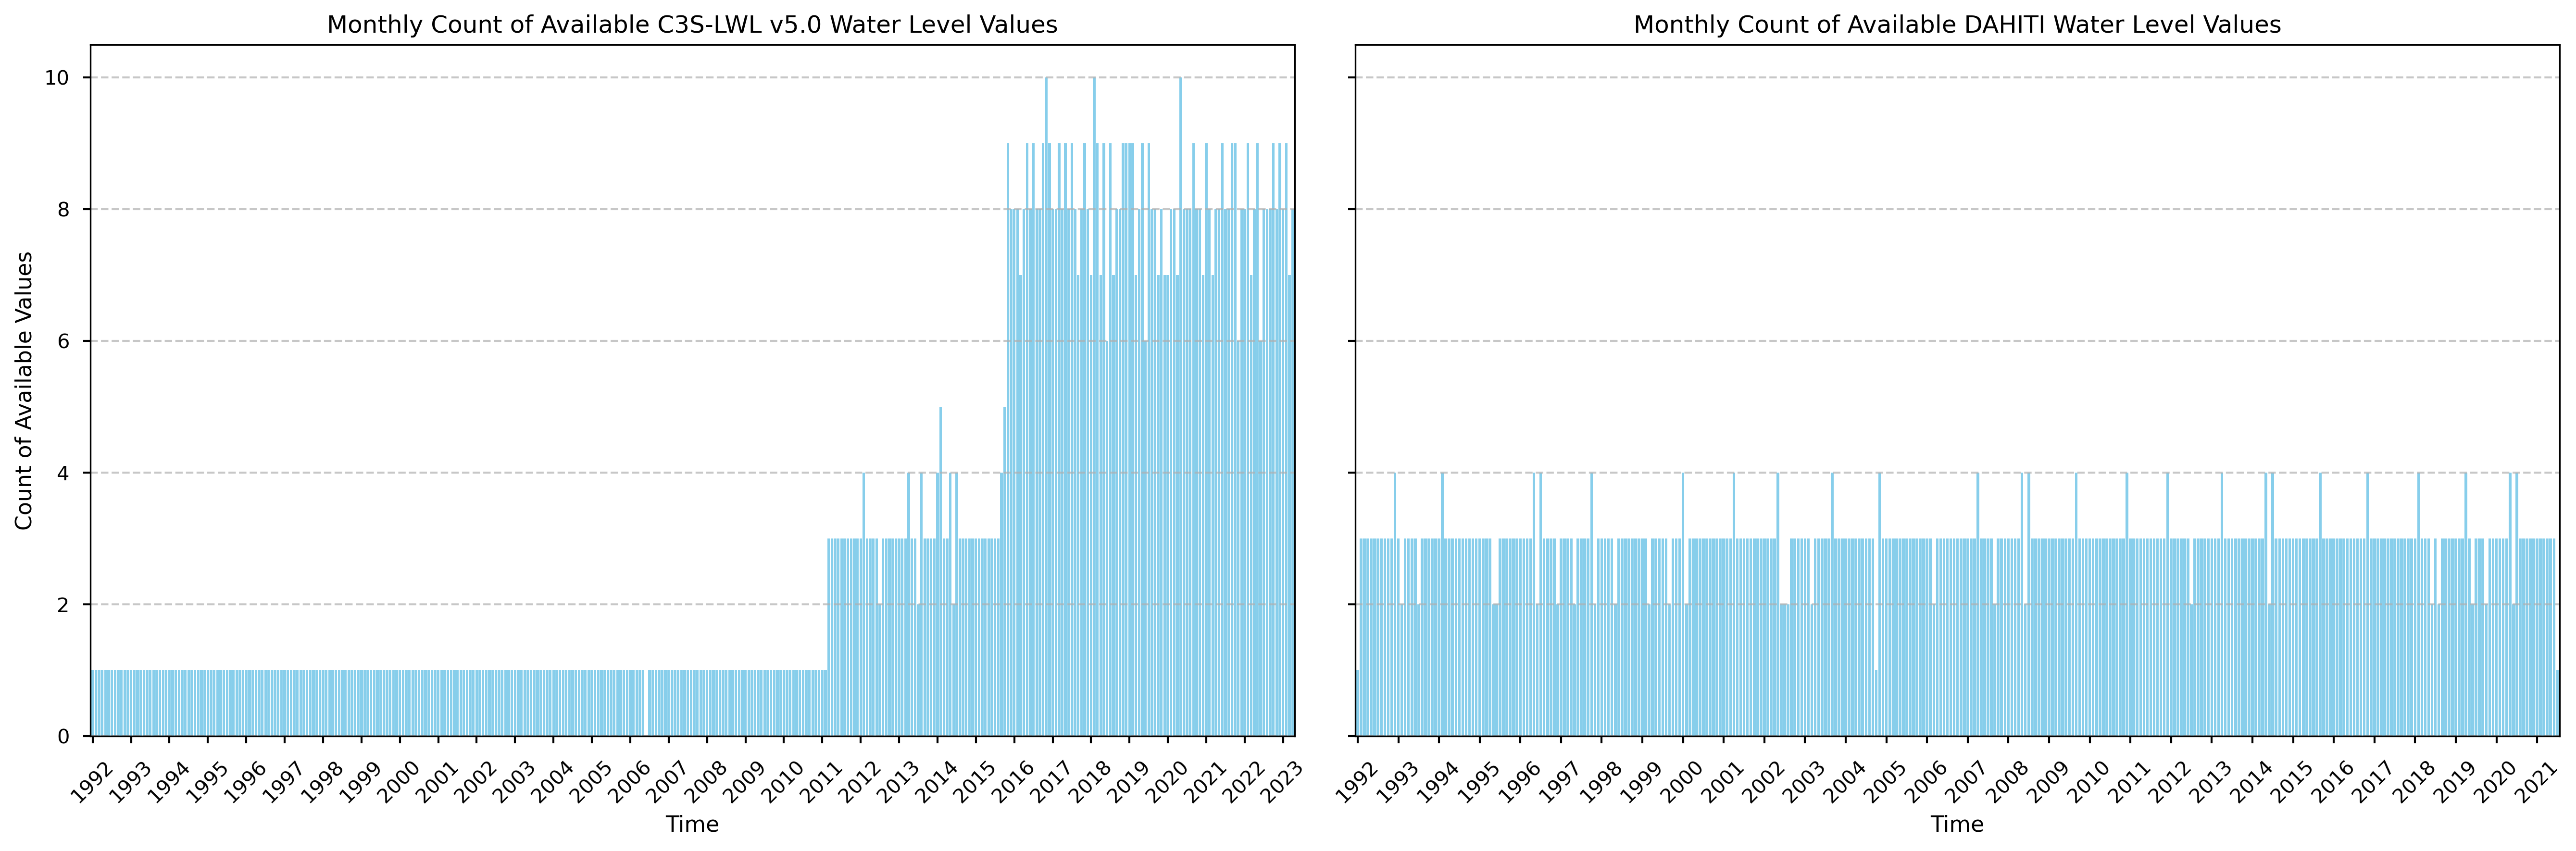

In [7]:
# First dataset: xarray object
monthly_counts_1 = da.resample(time="M").count().to_pandas()

# Second dataset: Pandas DataFrame
monthly_counts_2 = df_dahiti['water_level'].resample("M").count()

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(18, 6), dpi=300, sharey=True)

# Plot first bar chart
monthly_counts_1.plot(kind='bar', color='skyblue', width=0.8, ax=axes[0])
axes[0].set_title("Monthly Count of Available C3S-LWL v5.0 Water Level Values")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Count of Available Values")
axes[0].set_xticks(range(0, len(monthly_counts_1), 12))
axes[0].set_xticklabels(monthly_counts_1.index[::12].strftime('%Y'), rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot second bar chart
monthly_counts_2.plot(kind='bar', color='skyblue', width=0.8, ax=axes[1])
axes[1].set_title("Monthly Count of Available DAHITI Water Level Values")
axes[1].set_xlabel("Time")
axes[1].set_xticks(range(0, len(monthly_counts_2), 12))
axes[1].set_xticklabels(monthly_counts_2.index[::12].strftime('%Y'), rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()

*Figure 1. Comparison of count of monthly values over time available in the C3S-LWL v5.0 dataset (on the left) and in DAHITI (on the right).*

The DAHITI dataset exhibits a relatively consistent number of monthly observations, typically ranging from 1 to 4 throughout its entire temporal span. In contrast, the C3S-LWL v5.0 dataset shows variability in the number of monthly values, depending on the availability of satellite missions over time.
Up until the end of 2010, only one value per month was recorded. From 2011 to 2015, this number increased to mostly three observations per month, likely reflecting additional unfiltered data from the Jason-2 mission. A significant increase in observation frequency is evident from 2016 onward, corresponding to the introduction of Jason-3 and Sentinel-3A satellites. The C3S-LWL v5.0 dataset contains only one gap, in 2006, indicating strong overall temporal completeness.

The differing number of monthly observations between the datasets can be explained by the fact that DAHITI applies interpolation using a Kalman filter, a statistical technique that predicts the water level at the next time step based on previous observations and associated uncertainties [[1]](https://esd.copernicus.org/articles/15/225/2024/). This allows DAHITI to maintain a nearly uniform temporal resolution, achieving approximately three observations per month even during periods with limited satellite overpasses. On the other hand, the C3S-LWL v5.0 dataset does not interpolate. The observations from the different satellite missions are processed in three sequential steps, each applying thresholds and filtering criteria to remove bad-quality data. As a result, only high-quality data are retained in the final dataset. Because older satellite sensors generally had lower accuracy, a larger fraction of early observations is filtered out, whereas later missions contribute more usable data. More in depth information on the processing steps to make the C3S-LWL v5.0 dataset can be found in the Algorithm Theoretical Basis Document [(ATBD)](https://confluence.ecmwf.int/pages/viewpage.action?pageId=425328942).

#### Plot C3S and DAHITI's Water Level

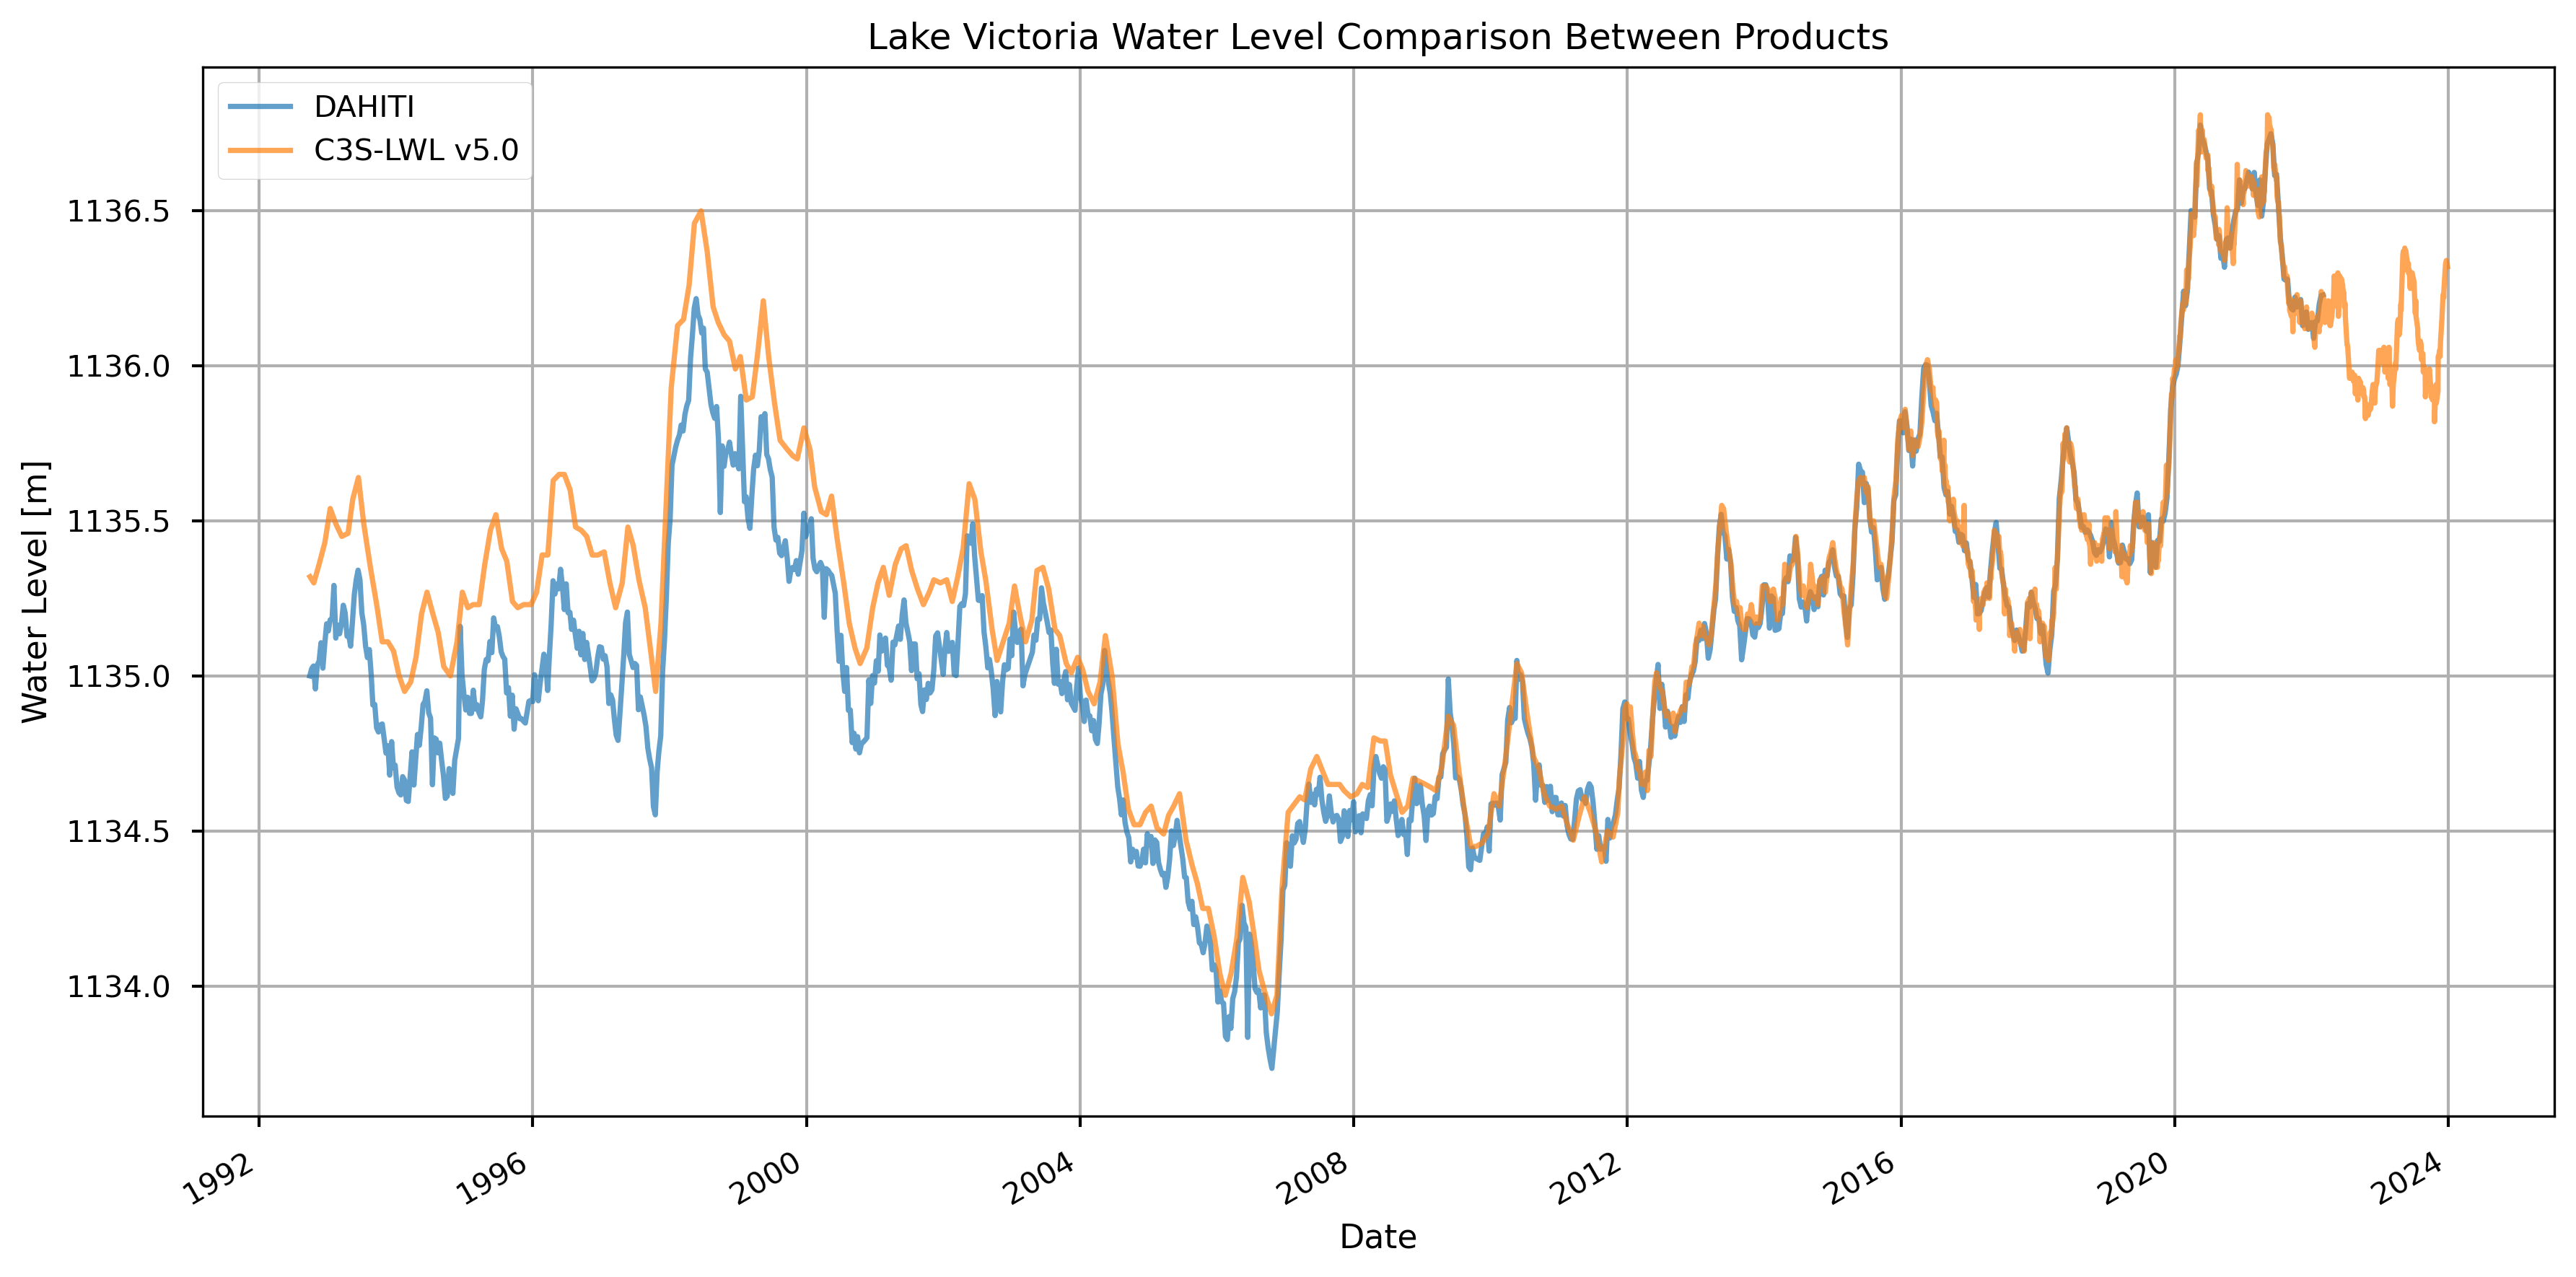

In [9]:
# Extract time series from xarray (da)
da_df = da.to_dataframe(name='water_level')
# Plotting
plt.figure(figsize=(12, 6), dpi=300)
df_dahiti['water_level_m'].plot(label='DAHITI', alpha=0.7)
da_df['water_level'].plot(label='C3S-LWL v5.0', alpha=0.7)

# Final touches
plt.title("Lake Victoria Water Level Comparison Between Products")
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Water Level [m]")
plt.legend()
plt.tight_layout()
plt.show()

*Figure 2. Lake Victoria's water level from 1992 to present from C3S-LWL v5.0 and DAHITI.*

In [10]:
# Extract time series from xarray (da)
df_c3s = da.to_dataframe(name='water_level_c3s')
df_c3s = df_c3s.dropna()
df_c3s.index.name = 'datetime'

# Align by nearest timestamp
comparison_df = pd.merge_asof(
    df_c3s,
    df_dahiti.reset_index()[['datetime', 'water_level_m']].rename(columns={'water_level_m': 'water_level_dahiti'}),
    on='datetime',
    direction='nearest',
    tolerance=pd.Timedelta("3D")
)

# Drop rows where no match was found
comparison_df = comparison_df.dropna()

# Compute difference
comparison_df['diff'] = comparison_df['water_level_c3s'] - comparison_df['water_level_dahiti']

# Ensure the datetime column is in datetime format
comparison_df['datetime'] = pd.to_datetime(comparison_df['datetime'])

# Define periods
periods = {
    '1992-2002 (TOPEX/Poseidon)': ('1992-01', '2001-12'),
    '2002-2016': ('2002-01', '2015-12'),
    '2016-2023': ('2016-01', '2023-12')
}

# Calculate average differences using the datetime column
for label, (start, end) in periods.items():
    mask = (comparison_df['datetime'] >= start) & (comparison_df['datetime'] <= end)
    avg_diff = comparison_df.loc[mask, 'diff'].mean()
    print(f"Average difference for {label}: {avg_diff:.3f} m")

Average difference for 1992-2002 (TOPEX/Poseidon): 0.334 m
Average difference for 2002-2016: 0.043 m
Average difference for 2016-2023: 0.002 m


The difference in water level estimates for Lake Victoria between the DAHITI and C3S-LWL v5.0 datasets varies noticeably over time (see *Figure 2*). A larger discrepancy is observed during the first decade of the time series (1992-2002), when the only satellite data available originated from the TOPEX/Poseidon mission. During this period, the average difference between the two datasets is 33.2 cm in average, with C3S values consistently higher than those from DAHITI.

This early discrepancy appears to stem from differences in the algorithms and retracking methods used by the two datasets. DAHITI, in some cases, applies an improved 10% threshold retracker for better perfomance on inland water bodies, depending on the specific case. However, specific information on whether the 10% retracker was applied to Lake Victoria could not be confirmed, since available documentation only details its application for lakes in the Americas. Additionally, DAHITI employs a Kalman filter to interpolate and smooth its time series, further influencing the results [[2]](https://hess.copernicus.org/articles/19/4345/2015/hess-19-4345-2015.html). In contrast, according to the [ATBD](https://confluence.ecmwf.int/pages/viewpage.action?pageId=425328942), the C3S-LWL v5.0 dataset uses a ocean model retracking for large lakes such as Lake Victoria.

However, this difference diminishes noticeably after 2002 (less than 10 cm in average), as newer satellite missions introduced more frequent and accurate measurements. The influence of processing seems to be much smaller in later years, likely because the improvements in sensor technology and data availability reduce the impact of such methodological differences.

These findings are supported by the [PQAR](https://confluence.ecmwf.int/pages/viewpage.action?pageId=428248112), which includes Lake Victoria under the Southern Africa region. According to the PQAR, the Pearson correlation coefficient between DAHITI and C3S in this region is very close to 1, and the Unbiased Root Mean Square Error (URMSE) remains below 25%, indicating strong overall agreement in this region.

(satellite_satellite-lake-water-level_climate-and-weather-extremes_q01:section-3)=
### 3. Time series reconstruction

The temporal coverage of the C3S-LWL dataset varies by lake, with a target record length of more than 25 years and a minimum threshold of 10 years. To increase statistical confidence and improve robustness, other available datasets can be merged with C3S-LWL to form a single continuous record.

The code on this section is based on the work of Pietroiusti et al. (2024) [[1]](https://esd.copernicus.org/articles/15/225/2024/).

#### Load and preprocess HYDROMET data

From January 1, 1948 to August 1, 1996, daily in situ water level measurements at the Jinja station were obtained from the WMO Hydrometeorological Survey (hereafter referred to as HYDROMET) [[3]](https://library.wmo.int/records/item/54830-hydrometeorological-survey-of-the-catchments-of-lakes-victoria-kyoga-and-albert?offset=32). These measurements, originally recorded as water depth at the lake’s outflow, were later converted to meters above sea level by adding a geoid correction of 1122.887 m, following the approach of Vanderkelen et al. (2018) [[4]](https://hess.copernicus.org/articles/22/5509/2018/).

The HYDROMET dataset is located in the [Zenodo](https://zenodo.org/records/10793917) repository at: lakevic-eea-data-zenodo\lakevic-eea-data-zenodo\lakevic-eea-analysis\lakelevels\Jinja_lakelevels_Van.txt.

In [11]:
# Load data
(hydromet_file,) = [
    fname for fname in fnames if fname.endswith("Jinja_lakelevels_Van.txt")
]
HYDROMET_raw = pd.read_csv(
    hydromet_file,
    sep="\t",
    header=None,
)

# Pre-process data
HYDROMET_raw.columns = ["year", "month", "day", "water level", "meas"]
HYDROMET_dates = pd.to_datetime(HYDROMET_raw[["year", "month", "day"]])
df = pd.DataFrame(HYDROMET_dates, columns=["date"])
df[["water_level", "meas"]] = HYDROMET_raw[["water level", "meas"]]
HYDROMET = df.set_index(["date"])
# Replace HYDROMET zeros with NaN, so that Matplotlib won't connect the points
HYDROMET["water_level"] = HYDROMET["water_level"].replace(0, np.nan)
HYDROMET["meas"] = HYDROMET["meas"].replace(0, np.nan)
HYDROMET

,water_level,meas
date,,
1948-01-01,1134.097,11.210
1948-01-02,1134.102,11.215
1948-01-03,1134.062,11.175
1948-01-04,1134.052,11.165
1948-01-05,1134.077,11.190
...,...,...
1996-07-28,1134.777,11.890
1996-07-29,1134.757,11.870
1996-07-30,1134.752,11.865


#### Merging the datasets together

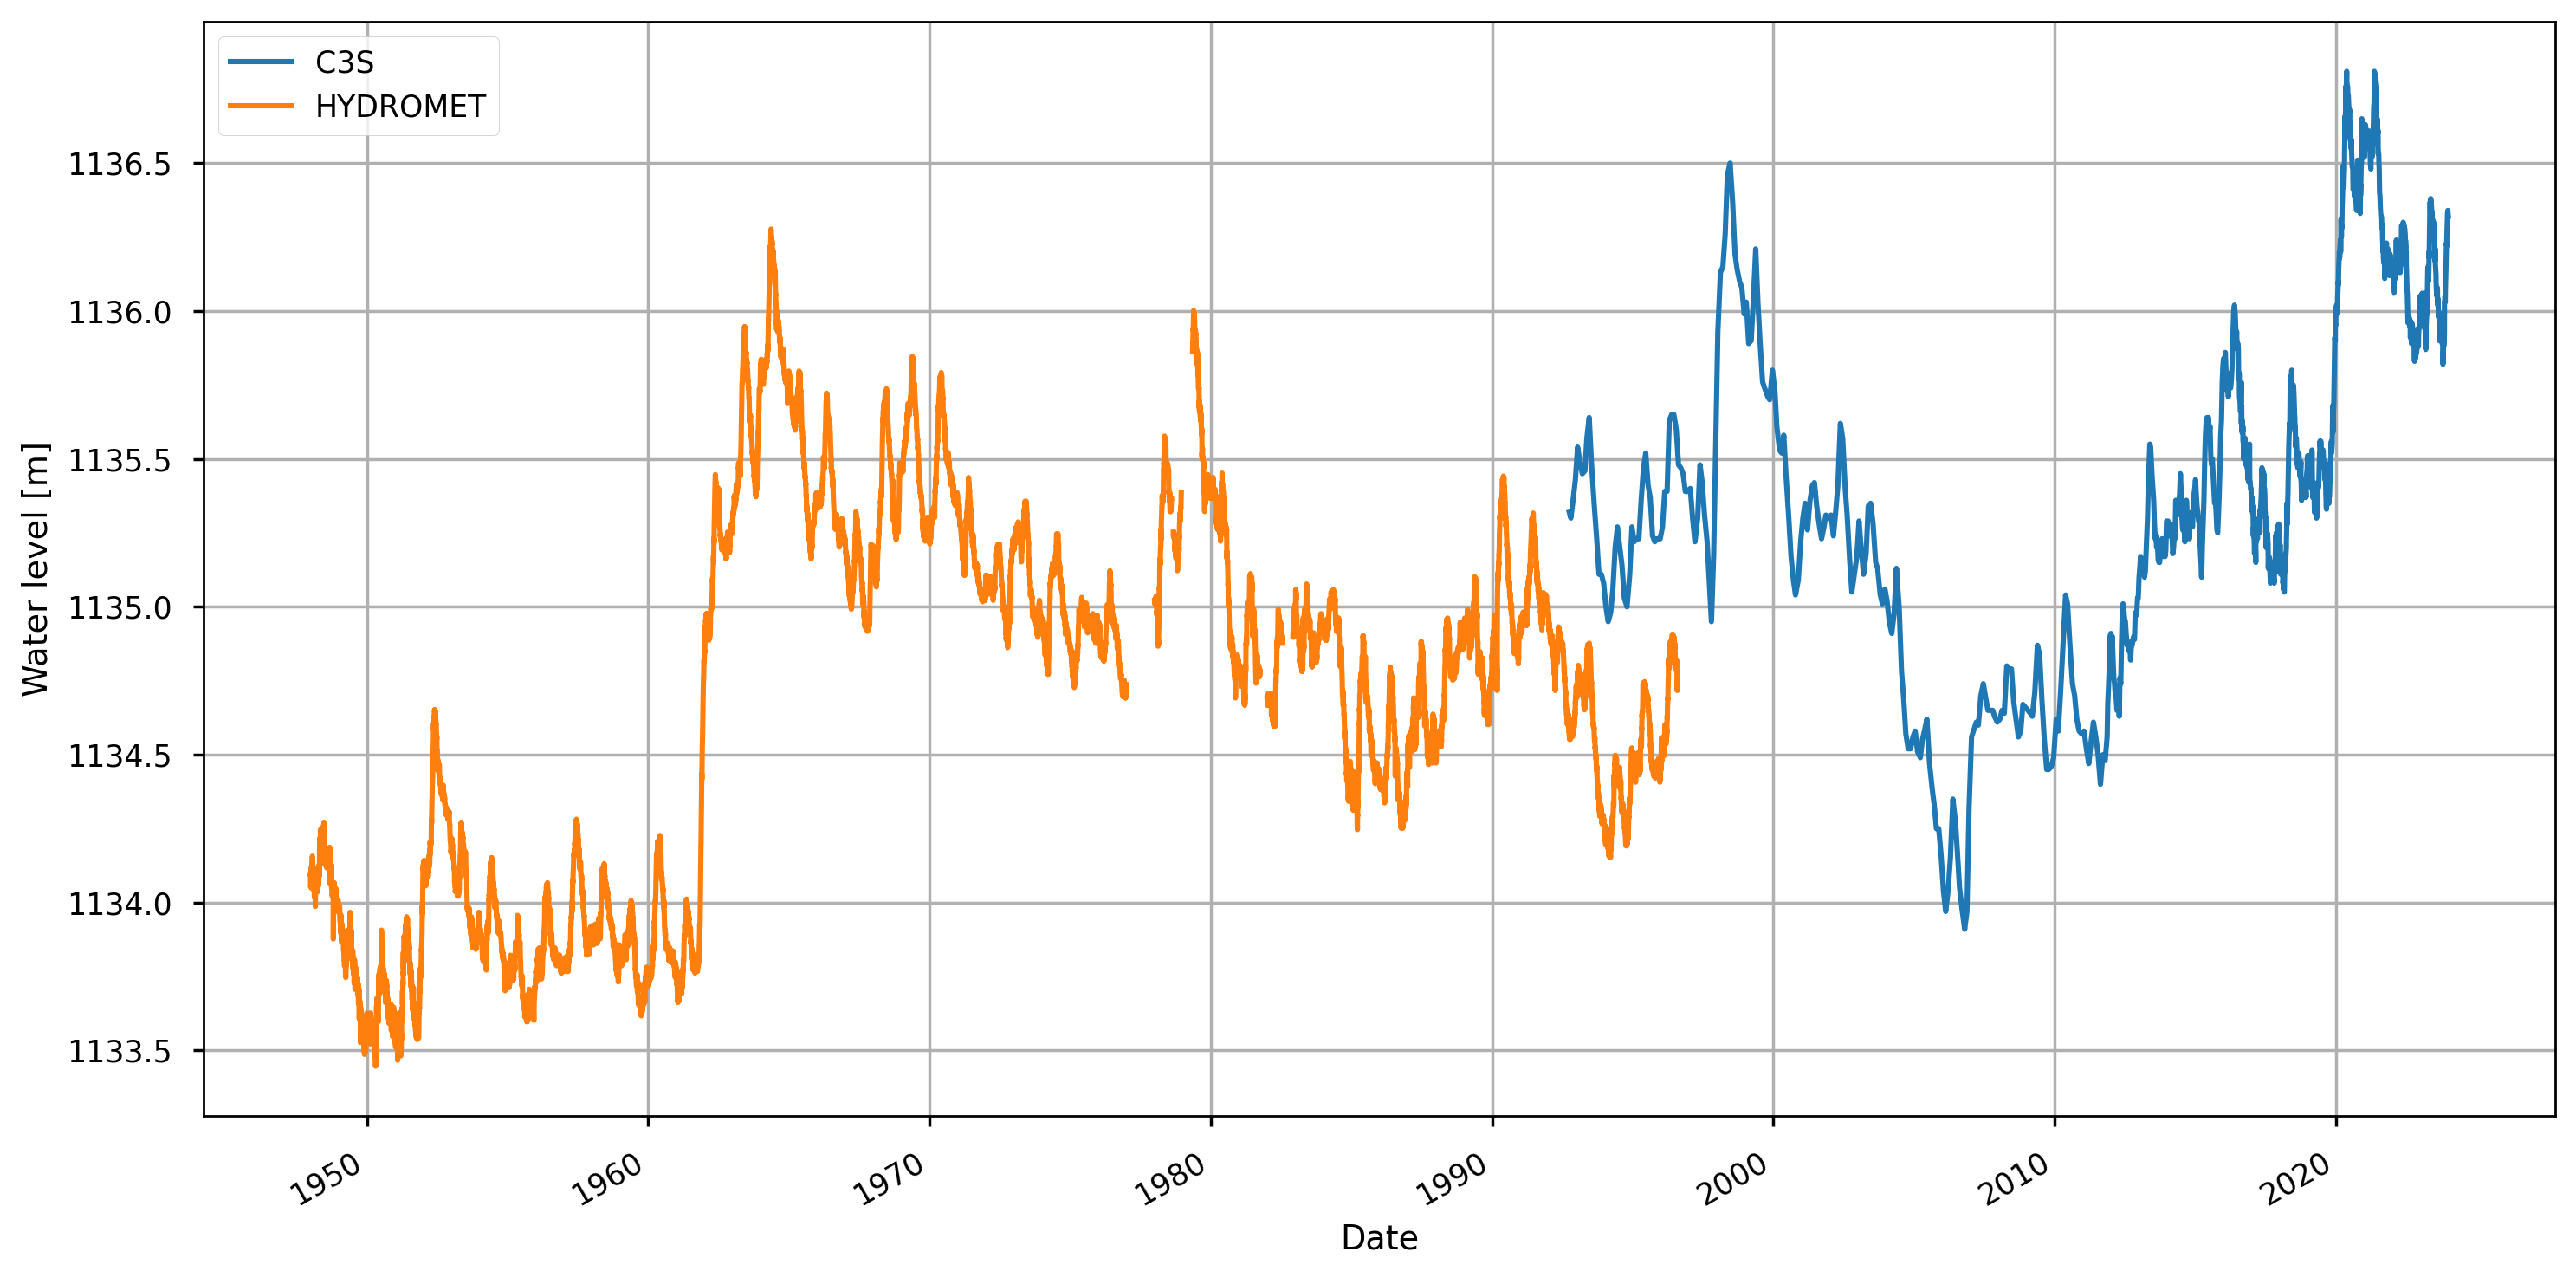

In [12]:
C3S=da_df
fig, ax = plt.subplots(figsize=(12, 6),dpi=250)
C3S['water_level'].plot(ax=ax, label="C3S")
HYDROMET['water_level'].plot(ax=ax, label="HYDROMET")
ax.grid(True)
ax.legend()
plt.xlabel("Date")
plt.ylabel("Water level [m]")
fig.tight_layout()
plt.show()

*Figure 3. HYDROMET (1948-1996) and C3S (1992-2023) datasets timeseries before correction.*

To obtain the reconstructed dataseries of Lake Victoria's water levels it is necessary to perform a correction to HYDROMET data based on the overlaping period (1992-1996). 

In [13]:
# Merge the two time-series, key on date, keep all observations (outer)
d_HYDROMET = HYDROMET.drop(['meas'], axis=1)
d_C3S = C3S.rename_axis('date')
d_C3S.index = pd.to_datetime(d_C3S.index).normalize()
df_merge = pd.merge(d_HYDROMET, d_C3S, how='outer', on='date')
df_merge.columns = ['HYDROMET', 'C3S']
df_merge.index = df_merge.index.normalize()

# Get only the overlapping observations
df_overlap = df_merge.query('HYDROMET == HYDROMET & C3S == C3S')
df_overlap.head() # 137 rows [1992-09-28 : 1996-07-18] 

,HYDROMET,C3S
date,,
1992-09-28,1134.567,1135.32
1992-10-18,1134.572,1135.30
1992-11-15,1134.597,1135.36
1992-12-16,1134.672,1135.43
1993-01-14,1134.767,1135.54


In [15]:
avg_diff = (df_overlap['C3S'] - df_overlap['HYDROMET']).mean() # C3S overestimates vs. HYDROMET
n_diff = len(df_overlap)
std_diff = (df_overlap['C3S'] - df_overlap['HYDROMET']).std()
print('Average Difference (C3S - HYDROMET) =', round(avg_diff,3)*100, ' ± ', round(std_diff,3)*100, ' cm')

Average Difference (C3S - HYDROMET) = 77.8  ±  3.0  cm


In [16]:
# Snap the two timeseries together, add avg diff to HYDROMET 
HYDROMET_corr = HYDROMET.copy()
HYDROMET_corr['water_level'] = HYDROMET['water_level'] + round(avg_diff,2)

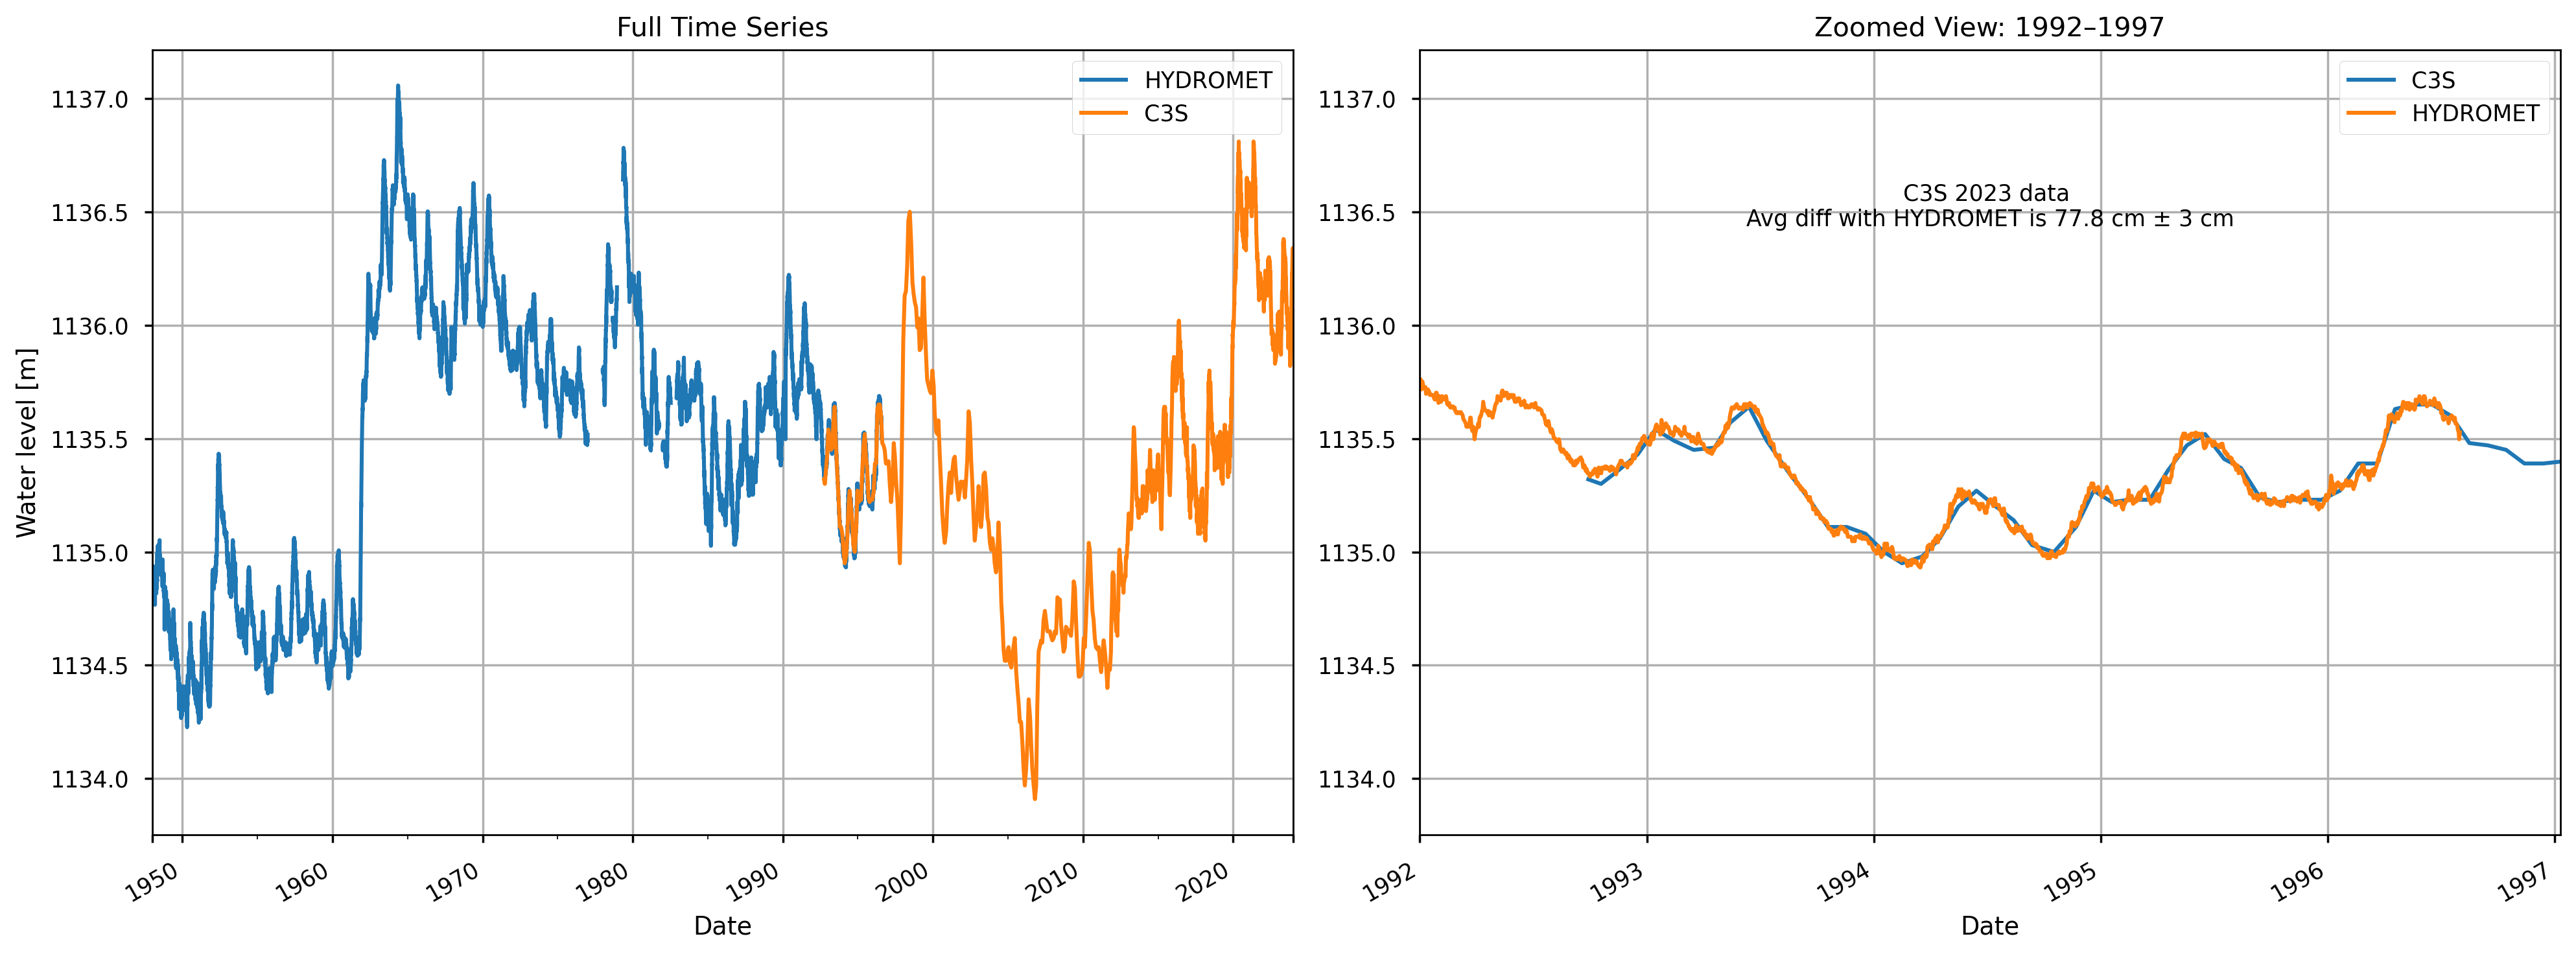

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=250)

# Left Plot: Full time series
HYDROMET_corr['water_level'].plot(ax=axes[0], label="HYDROMET")
C3S['water_level'].plot(ax=axes[0], label="C3S")

min_date = min(HYDROMET_corr.index.min(), C3S.index.min())
max_date = max(HYDROMET_corr.index.max(), C3S.index.max())
axes[0].set_xlim([min_date, max_date])
axes[0].set_title("Full Time Series")
axes[0].set_ylabel("Water level [m]")
axes[0].set_xlabel("Date")
axes[0].legend()
axes[0].grid(True)

# Right Plot: Zoomed section
C3S['water_level'].plot(ax=axes[1], label="C3S")
HYDROMET_corr['water_level'].plot(ax=axes[1], label="HYDROMET")

axes[1].set_xlim(['1992-01-01', '1997-01-10'])
axes[1].set_title("Zoomed View: 1992–1997")
axes[1].set_xlabel("Date")
axes[1].legend()
axes[1].grid(True)
axes[1].text(0.5, 0.8, "C3S 2023 data \nAvg diff with HYDROMET is 77.8 cm ± 3 cm",
             transform=axes[1].transAxes,
             ha='center', va='center')

# Layout
fig.tight_layout()
plt.show()

*Figure 4. HYDROMET (1948-1996) and C3S (1992-2023) datasets timeseries after correction.*

The average difference between the two datasets is 77.8 ± 3.0 cm [[1]](https://esd.copernicus.org/articles/15/225/2024/). The HYDROMET dataset was corrected using this value.

In [18]:
#Correct for difference
startHYDROMET = np.datetime64('1948-01-01')
endHYDROMET = np.datetime64('1996-08-01')

startC3S = np.datetime64('1992-09-28')
endC3S = np.datetime64('2023-12-27') 

# Overwriting time-series with C3S where available
HYDROMET_keep = HYDROMET_corr.loc[ startHYDROMET : (startC3S - pd.Timedelta("1 day")) ]
HYDROMET_keep = HYDROMET_keep.drop(columns=['meas'])

In [19]:
#To have only one value per day 
C3S_keep = C3S.rename_axis('date')
C3S_keep = C3S_keep.resample('D').mean().dropna()
# Make only one list with HYDROMET+C3S data
df_list = [HYDROMET_keep, C3S_keep]
lakelevels_all_raw = pd.concat(df_list, ignore_index=False)
pd.set_option("display.precision", 8)

In [20]:
# Round to 2 sig figs 
lakelevels_all = lakelevels_all_raw.round(2)
pd.set_option("display.precision", 8)

In [21]:
# Calculate basic statistics for the 'water_level' column
meanL = lakelevels_all['water_level'].mean()  # Mean water level
maxL = lakelevels_all['water_level'].max()    # Maximum water level
minL = lakelevels_all['water_level'].min()    # Minimum water level

# Calculate 10% trimmed mean (removes lowest and highest 10% of values)
mtrim = stats.trim_mean(lakelevels_all[['water_level']], 0.1)
mtrim = mtrim.flatten().tolist()[0]  # Convert from array to scalar

# Calculate percentiles
p10 = scipy.stats.scoreatpercentile(lakelevels_all[['water_level']], 10)  # 10th percentile
p90 = scipy.stats.scoreatpercentile(lakelevels_all[['water_level']], 90)  # 90th percentile

In [22]:
# Interpolate to daily res and round to 2 sig figs
lakelevels_intr = lakelevels_all.resample('D').asfreq().interpolate(method='linear').round(2)

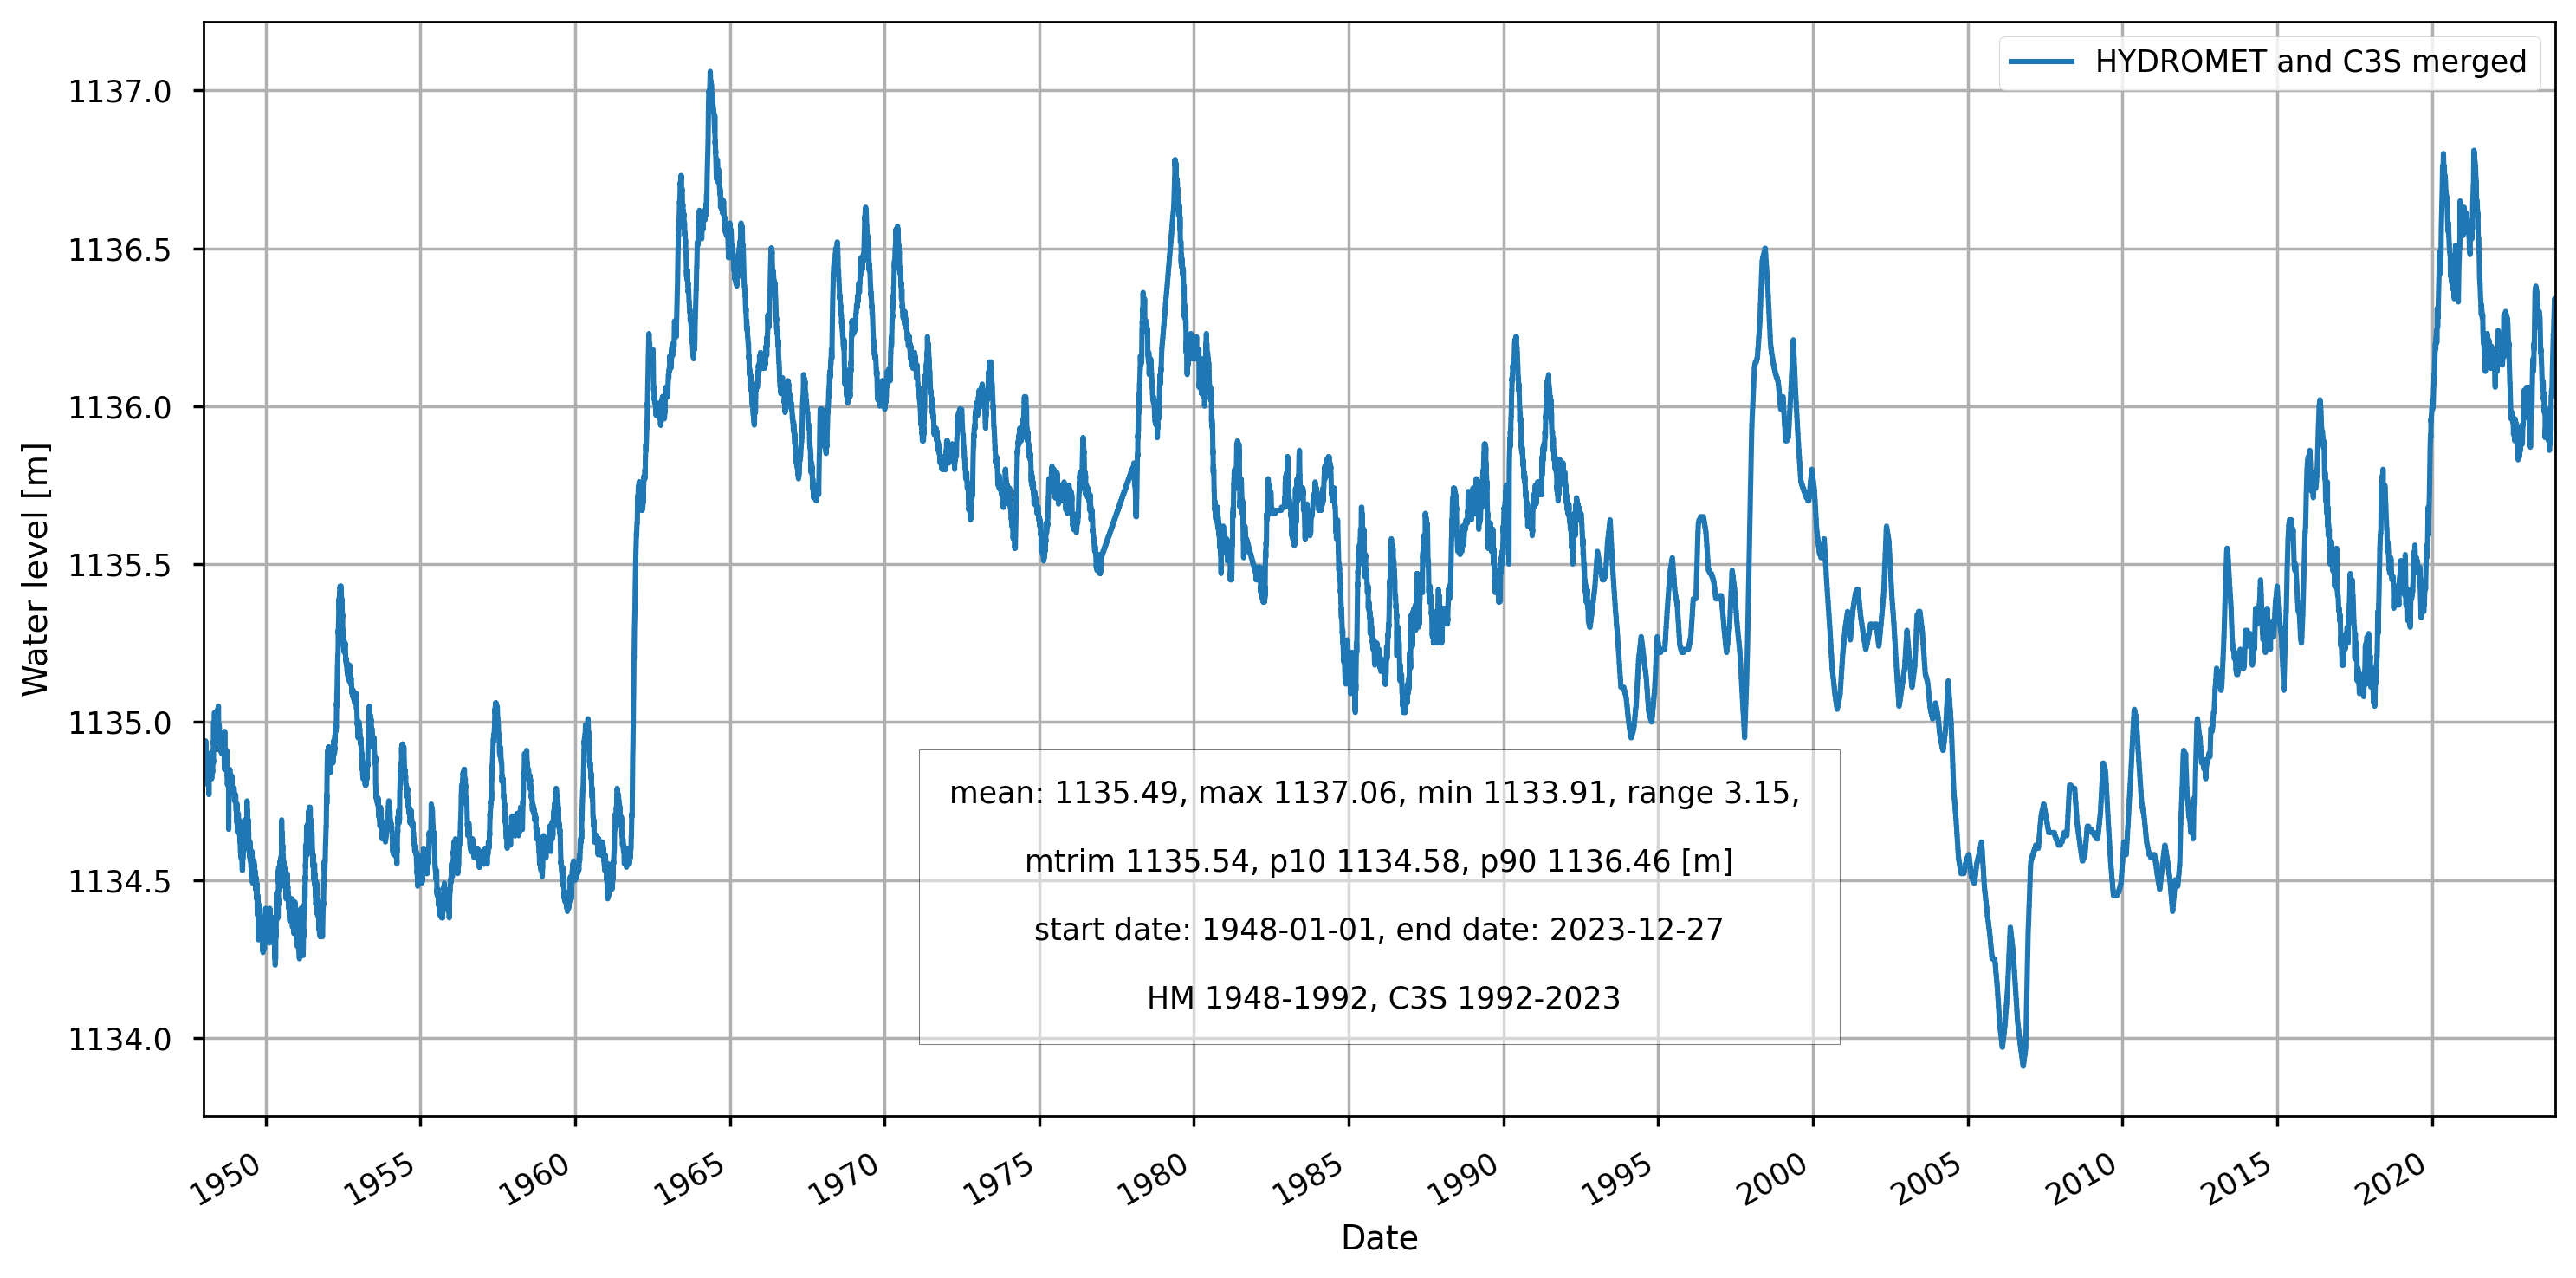

In [23]:
#Plot the complete water levels timeseries with the statistics calculated
left = '1948-01-01'
right = '2023-12-27'

fig, ax = plt.subplots(figsize=(12, 6), dpi=250)
lakelevels_intr['water_level'].plot(ax=ax, label="HYDROMET and C3S merged")
ax.grid(True)
ax.legend()
plt.xlabel("Date")
plt.ylabel("Water level [m]")
ax.set_xlim(left, right)
plot_text = ('mean: {:.2f}, max {:.2f}, min {:.2f}, range {:.2f}, \n \n mtrim {:.2f}, p10 {:.2f}, p90 {:.2f} [m] \n \n start date: {}, end date: {} \n \n HM 1948-1992, C3S 1992-2023'
             .format(meanL, maxL, minL, maxL-minL, mtrim, p10,p90, left, right))  #, start date {:.3f}, end date {:.3f} 
ax.text(0.5, 0.2, (plot_text),
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transAxes, 
        bbox={'facecolor':'white', 'alpha':0.5, 'pad':10})
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.autofmt_xdate()
fig.tight_layout()
plt.show()

*Figure 5. Reconstructed Lake Victoria's water levels timeseries (1948-2023).*

A single dataset combining both sources was created. For the overlap period between 1992 and 1997, C3S LWL-v5.0 data were used when available. The gaps were filled by interpolation to have a daily resolution.

(satellite_satellite-lake-water-level_climate-and-weather-extremes_q01:section-4)=
### 4. Probabilistic extreme event analysis

Pietroiusti et al. (2024) [[1]](https://esd.copernicus.org/articles/15/225/2024/) assessed the influence of anthropogenic climate change on the 2020 Lake Victoria floods using the extreme event attribution framework outlined by Philip et al. (2020) [[5]](https://ascmo.copernicus.org/articles/6/177/2020/) and van Oldenborgh et al. (2021) [[6]](https://doi.org/10.1007/s10584-021-03071-7). The methodology follows a structured sequence of steps: (i) defining the event, (ii) estimating probabilities and trends based on observational data, (iii) validating climate models, (iv) conducting attribution using multiple models and methods, and (v) synthesizing the findings into clear attribution statements.

In this assessment, only the first step, event definition, is performed, using reconstructed Lake Victoria water level time series from the HYDROMET dataset and the C3S LWL-v5.0 product. The aim is to assess whether the C3S LWL-v5.0 dataset is suitable for use in attribution analyses of this kind. While the remaining steps involve model simulations and additional data sources that are beyond the scope of this assessment, the assumption is that if the observational component is consistent, the full attribution framework could, in principle, be applied using this dataset as well.

#### Event definition

The variable chosen for analysis is the rate of change in water levels (ΔL) over a time window (Δt), with Δt set to 180 days since most of the level rise in the 2020 Lake Victoria flooding occurred during the six-month period between November 2019 and May 2020 [[1]](https://esd.copernicus.org/articles/15/225/2024/). The code computes ΔL for every possible 180-day interval in the dataset, groups these values by year, and identifies the single largest 180-day change for each year, this is the the annual block maximum. The annual block maxima are then ranked to compare the magnitude of events across years. Finally, the ranking and maximum ΔL/Δt for 2020 are reported.

In [24]:
# Set the time window (dt)
dt = 180  # days
lakelevels_intr[f'dLdt_{dt}'] = lakelevels_intr['water_level'] - lakelevels_intr['water_level'].shift(dt)

# Extract annual block maxima
df_block = lakelevels_intr[[f'dLdt_{dt}']].copy()
df_block['year'] = df_block.index.year

# Keep only years with full data
all_years = df_block['year'].unique()
if df_block[df_block['year'] == all_years[-1]].shape[0] < 365:
    valid_years = all_years[1:-1]
else:
    valid_years = all_years[1:]

records = []
for year in valid_years:
    year_data = df_block[df_block['year'] == year]
    max_val = year_data[f'dLdt_{dt}'].max()
    max_day = year_data[year_data[f'dLdt_{dt}'] == max_val].index[0]
    records.append((year, max_val, max_day))

df_max = pd.DataFrame(records, columns=['year', f'dLdt_{dt}', 'date']).set_index('year')

# Calculate rank of each year
df_max['rank'] = df_max[f'dLdt_{dt}'].rank(ascending=False).astype(int)

# Print 2020 event details
if 2020 in df_max.index:
    val = df_max.loc[2020, f'dLdt_{dt}']
    rank = df_max.loc[2020, 'rank']
    print(f"🔹 2020 ΔL/Δt (180 days): {val:.3f} m")
    print(f"🔹 2020 Rank: {rank} out of {len(df_max)} years")
else:
    print("2020 is not in the index. Check your data coverage.")

🔹 2020 ΔL/Δt (180 days): 1.210 m
🔹 2020 Rank: 3 out of 74 years


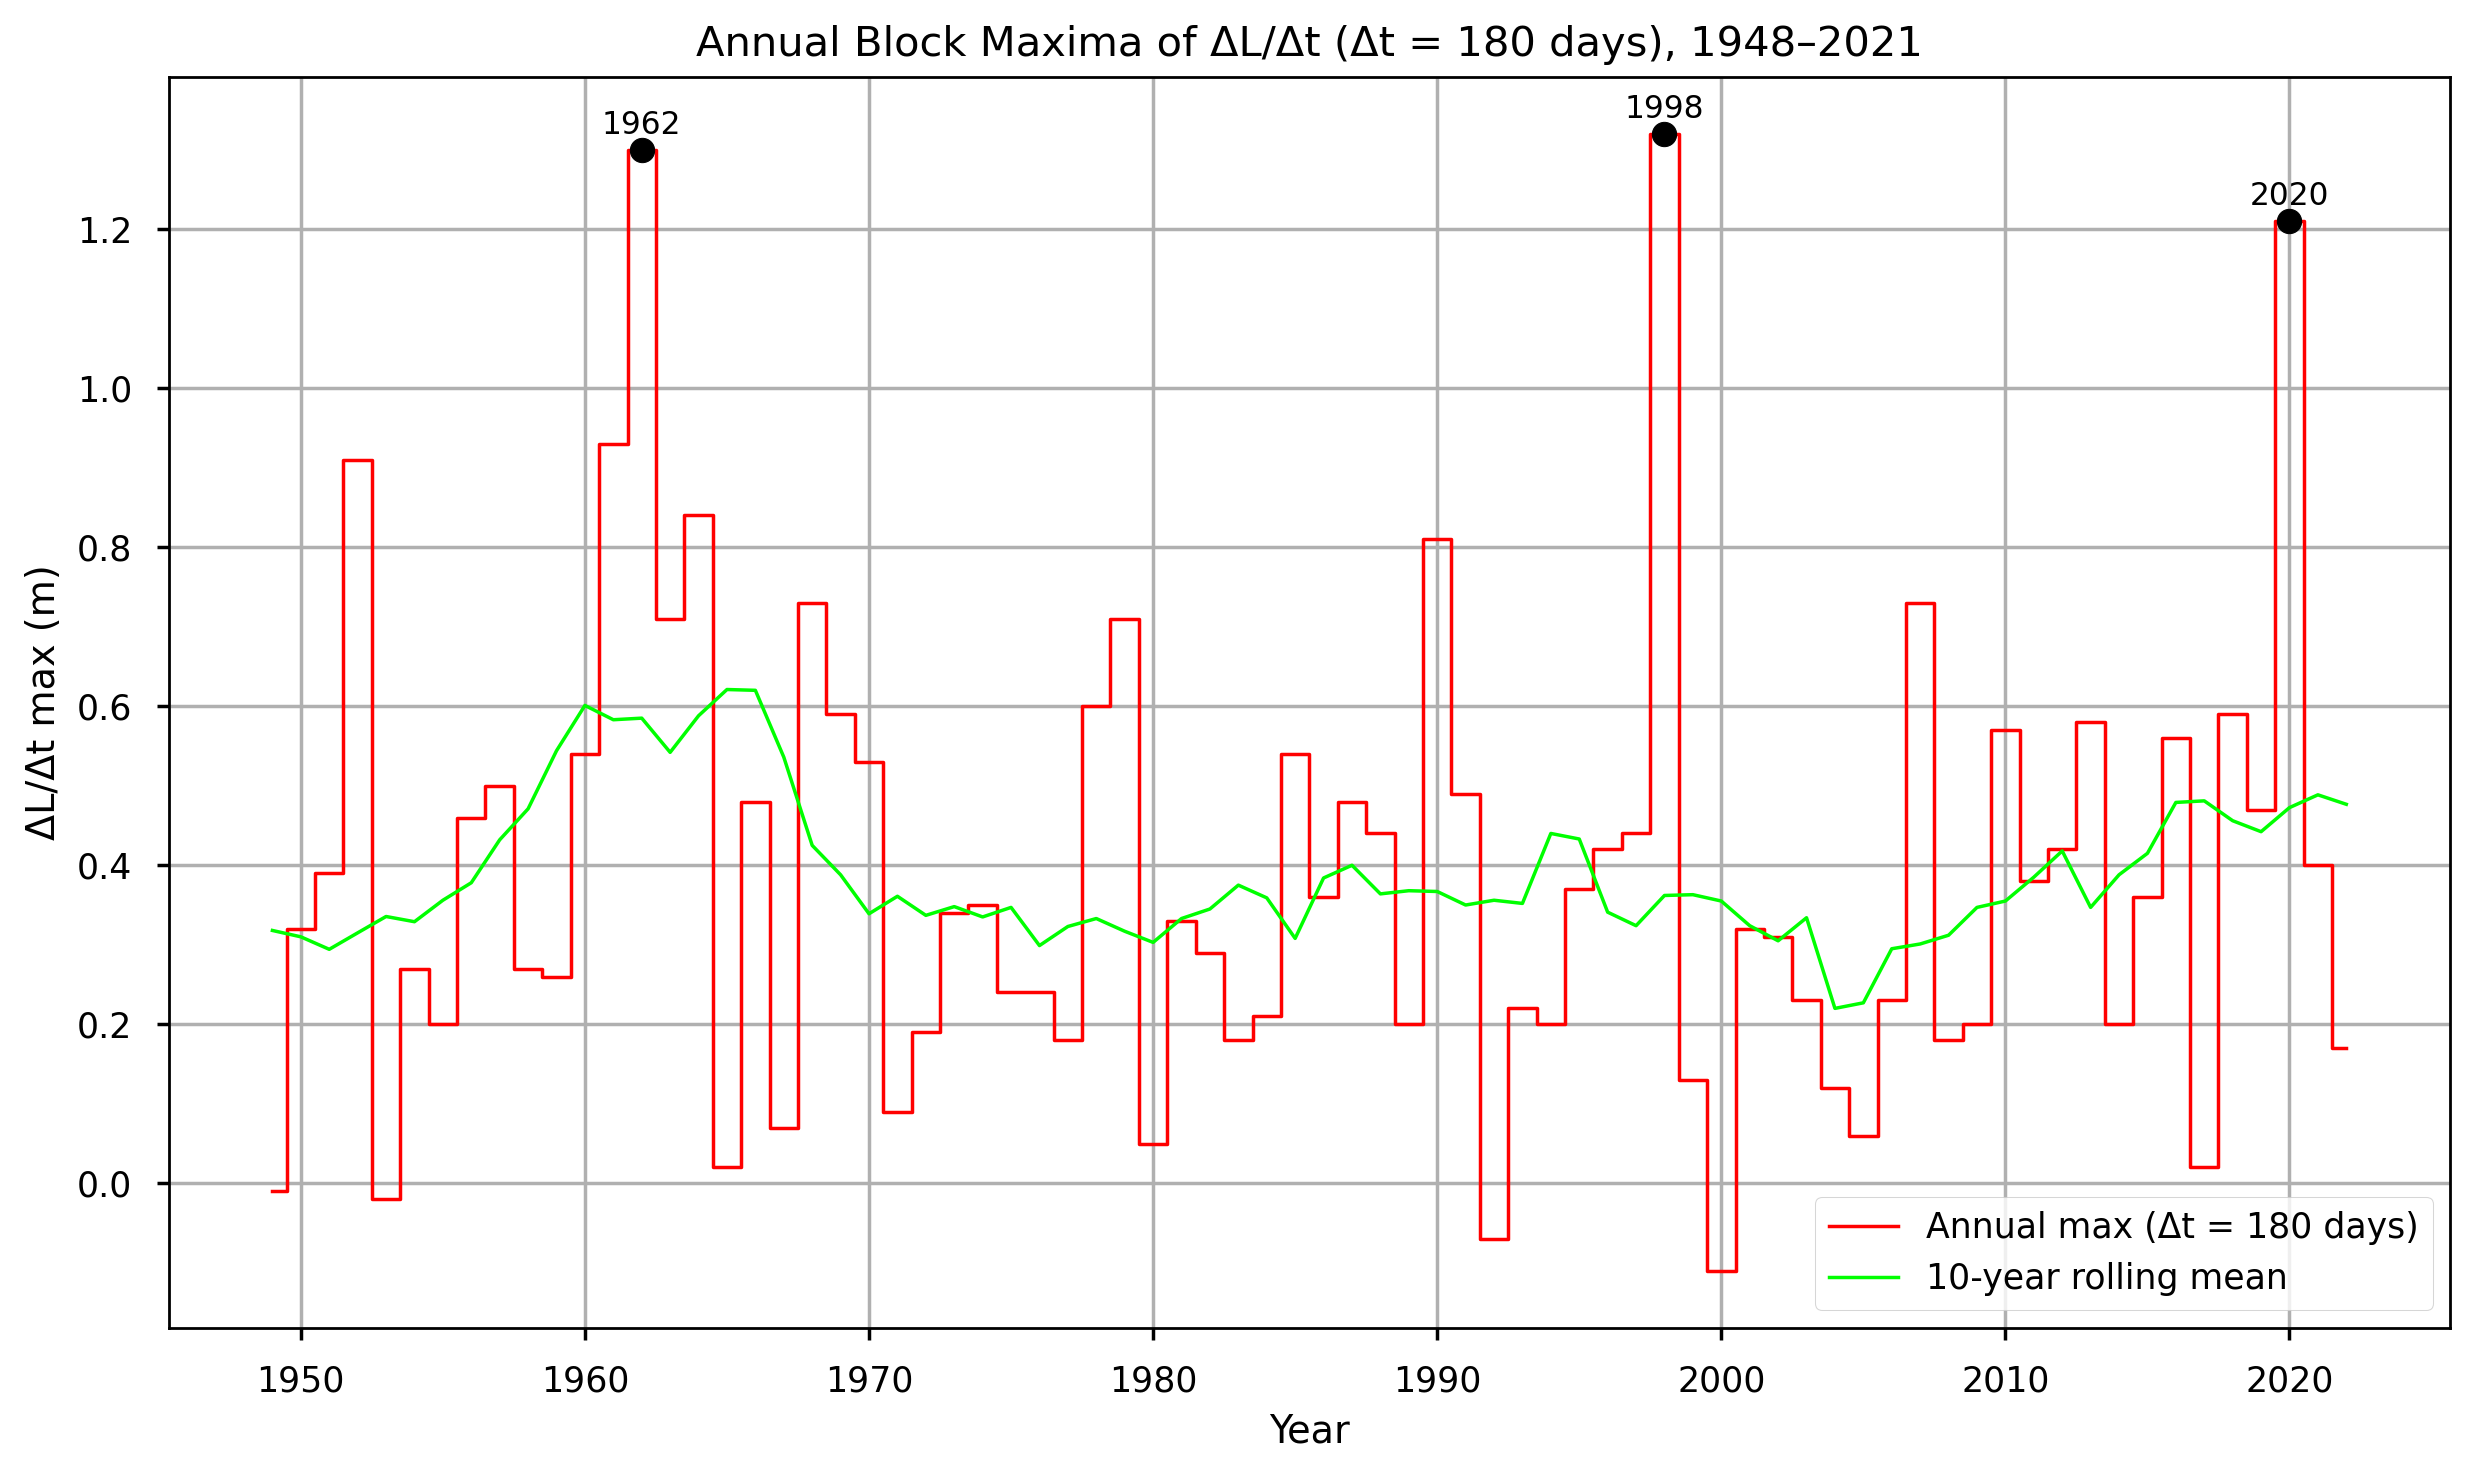

In [25]:
# Ensure rolling mean exists
df_max['rolling_mean'] = df_max[f'dLdt_{dt}'].rolling(window=10, center=True, min_periods=1).mean()

# Get top 3 values
top3 = df_max.sort_values(by=f'dLdt_{dt}', ascending=False).head(3)

# Plot
plt.figure(figsize=(10, 6), dpi=250)

# Step plot for annual maxima (red)
plt.step(df_max.index, df_max[f'dLdt_{dt}'], where='mid', color='red', linewidth=1,label=f'Annual max (Δt = {dt} days)')

# Rolling mean (green)
plt.plot(df_max.index, df_max['rolling_mean'], color='lime', linewidth=1, label='10-year rolling mean')

# Top 3 events (black markers + labels)
for idx, row in top3.iterrows():
    plt.scatter(idx, row[f'dLdt_{dt}'], color='black', zorder=5)
    plt.text(idx, row[f'dLdt_{dt}'] + 0.02, f"{row['date'].year}", ha='center', fontsize=9, color='black')

# Labels, title, grid
plt.title(f'Annual Block Maxima of ΔL/Δt (Δt = {dt} days), 1948–2021')
plt.xlabel('Year')
plt.ylabel(f'ΔL/Δt max (m)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

*Figure 6. Annual block maxima time series $(\Delta L / \Delta t)_{\text{max}}$ with Δt=180 d for the period 1897–2021 and 10-year rolling mean of the time series (using C3S-LWL v5.0 data).*

```{figure} e4f5e3f5-af36-4613-9df5-03a4f99fde20.png
```
*Figure 7. Annual block maxima time series $(\Delta L / \Delta t)_{\text{max}}$ with Δt=180 d for the period 1897–2021 and 10-year rolling mean of the time series (using DAHITI data). Source: Pietroiusti et al. (2022) [[7]](https://cris.vub.be/ws/portalfiles/portal/95073120/Geography_MSc_thesis_Rosa_Pietroiusti_final.pdf)*

The results of this analysis are consistent with those reported by Pietroiusti et al. (2024) [[1]](https://esd.copernicus.org/articles/15/225/2024/). According to the C3S-LWL v5.0 dataset, the year 2020 recorded the third-largest 180-day lake level rise, surpassed only by 1962 and 1998. The magnitude of the 2020 rise was 1.21 meters, which matches the value obtained by Pietroiusti et al. using the DAHITI dataset.

However, some discrepancies emerge when comparing other years. For instance, in 2000, the C3S-LWL v5.0 data shows a negative value, indicating a consistent decrease in lake levels throughout the year (see *Figure 6*). Conversely, the corresponding figure in Pietroiusti et al. (2022) [[7]](https://cris.vub.be/ws/portalfiles/portal/95073120/Geography_MSc_thesis_Rosa_Pietroiusti_final.pdf) (see *Figure 7*) shows a slightly positive value.

These differences likely stem from variations in the underlying datasets, as discussed in [](satellite_satellite-lake-water-level_climate-and-weather-extremes_q01:section-2). In 2000, TOPEX/Poseidon was still the only mission providing data for the C3S-LWL, with only one value per month. Meanwhile, DAHITI applied Kalman-filtered interpolation, resulting in a denser time series. Because no reliable in situ data are available for this period, it is difficult to determine which dataset more accurately reflects reality.

Nevertheless, the agreement between both datasets on the 2020 block maximum strengthens confidence in the reliability of this result. Although C3S-LWL and DAHITI use different processing algorithms, the increased availability of satellite observations in recent years (particularly after 2016) has resulted in greater similarity between their outputs. With more frequent and higher-quality measurements from multiple missions, the differences between the datasets diminish, making the 1.21 meter increase observed in 2020 not only consistent across sources, but also giving more confidence in the result.

This assessment supports the suitability of the C3S-LWL v5.0 dataset for extreme event attribution applications, as the event-definition results closely match those from Pietroiusti et al. (2024) [[1]](https://esd.copernicus.org/articles/15/225/2024/). Since this step feeds directly into the rest of the workflow, similar outcomes would be expected in a full attribution analysis.

## ℹ️ If you want to know more

* NASA (2021). [Lake Victoria’s Rising Waters](https://earthobservatory.nasa.gov/images/148414/lake-victorias-rising-waters)
* ACSA Uganda & Uganda Coalition for Sustainble Development (UCSD) (2020). [The Implication of Floods to Food Security During and the Aftermath of COVID-19 Pandemic in Uganda](https://acsa-ug.org/wordpress/wp-content/uploads/2020/06/THE-IMPLICATION-OF-FLOODS-TO-FOOD-SECURITY-DURING-AND-THE-AFTERMATH-OF-COVID19-PANDEMIC-IN-UGANDA.pdf)

### Key resources

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [B-Open](https://www.bopen.eu/)

Dataset documentation:

* [LWL v5.0 and LWL-S v1.0: Product User Guide and Specification (PUGS)](https://confluence.ecmwf.int/pages/viewpage.action?pageId=425328964)
* [LWL v5.0 and LWL-S v1.0: Algorithm Theoretical Basis Document (ATBD)](https://confluence.ecmwf.int/pages/viewpage.action?pageId=425328942)
* [LWL v5.0 and LWL-S v1.0: Product Quality Assessment Report (PQAR)](https://confluence.ecmwf.int/pages/viewpage.action?pageId=428248112)


### References

[[1]](https://esd.copernicus.org/articles/15/225/2024/) Pietroiusti, R., Vanderkelen, I., Otto, F. E. L., Barnes, C., Temple, L., Akurut, M., Bally, P., van Lipzig, N. P. M., and Thiery, W. (2024). Possible role of anthropogenic climate change in the record-breaking 2020 Lake Victoria levels and floods, Earth Syst. Dynam., 15, 225–264.

[[2]](https://hess.copernicus.org/articles/19/4345/2015/hess-19-4345-2015.html) Schwatke, C., Dettmering, D., Bosch, W., and Seitz, F. (2015). DAHITI - an innovative approach for estimating water level time series over inland waters using multi-mission satellite altimetry: , Hydrol. Earth Syst. Sci., 19, 4345-4364.

[[3]](https://library.wmo.int/records/item/54830-hydrometeorological-survey-of-the-catchments-of-lakes-victoria-kyoga-and-albert?offset=32) WMO-UNPD (1974). Hydrometeorological Survey of the Catchments of Lakes Victoria, Kyoga
and Albert: Vol 1 Meteorology and Hydrology of the Basin.

[[4]](https://hess.copernicus.org/articles/22/5509/2018/) Vanderkelen, I., Van Lipzig, N. P., and Thiery, W. (2018). Modelling the water balance of Lake Victoria (East Africa)-Part 1: Observational analysis. Hydrology and Earth System Sciences, 22(10):5509–5525.

[[5]](https://ascmo.copernicus.org/articles/6/177/2020/) Philip, S., Kew, S., van Oldenborgh, G. J., Otto, F., Vautard, R., van der Wiel, K., King, A., Lott, F., Arrighi, J., Singh, R., and van Aalst, M. (2020). A protocol for probabilistic extreme event attribution analyses, Adv. Stat. Clim. Meteorol. Oceanogr., 6, 177–203.

[[6]](https://doi.org/10.1007/s10584-021-03071-7) G. J. van Oldenborgh, K. van der Wiel, S. Kew, S. Philip, F. Otto, R. Vautard, A. King, F. Lott, J. Arrighi, R. Singh, and M. van Aalst. Pathways and pitfalls in extreme event attribution.  Climatic Change, vol. 166, no. 1, p. 13, 2021.

[[7]](https://cris.vub.be/ws/portalfiles/portal/95073120/Geography_MSc_thesis_Rosa_Pietroiusti_final.pdf) Pietroiusti, R., Vanderkelen, I., van Lipzig, N. P. M., and Thiery, W. (2022). Was the 2020 Lake Victoria flooding ‘caused’ by anthropogenic climate change? An event attribution study. M.Sc. thesis, Dept. of Hydrology and Climate, Vrije Universiteit Brussel and KU Leuven.

[[8]](https://link.springer.com/book/10.1007/978-1-4471-3675-0) Coles, S. (2001). An Introduction to Statistical Modeling of Extreme Values. Springer Series in Statistics. Springer-Verlag London. ISBN: 978-1-85233-459-8.